In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np

import re
import os
import csv

import matplotlib.pyplot as plt

In [0]:
path="drive/capstone/"

In [0]:
CCL = pd.read_csv(path +"datas/CCL.csv", sep="\t")
def get_Date(s):
  return s.split("-")[1]
CCL["Date"] = CCL["Date"].apply(get_Date)
CCL["Date"] = pd.to_datetime(CCL.Date, format="%Y-%m-%d", errors='ignore')
CCL.set_index("Date", inplace=True)

In [6]:
for i in os.listdir(path+"stock_price"):
  code = i[:4]
  stock = pd.read_csv(path+"stock_price/{}.HK.csv".format(code))
  stock["Date"] = pd.to_datetime(stock.Date, format="%Y-%m-%d", errors='ignore')
  stock.set_index("Date", inplace=True)
  stock = stock.resample('W', 'last')["Close"]
  stock = stock.to_frame(name=code)
  CCL = pd.merge(CCL,stock, left_index=True, right_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


In [0]:
df = CCL.drop("CCL", axis=1)

In [8]:
df.head()

,0019,0003,0945,0390,0066,0062,0733,0488,0050,0127,...,1200,0432,0083,0054,0041,0020,0001,0017,0012,0016
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,72.349998,15.32,163.699997,5.78,45.799999,25.150000,3.43,13.30,8.86,12.60,...,2.26,3.04,13.84,28.850000,40.950001,55.799999,98.099998,11.74,51.500000,130.399994
2017-12-24,72.300003,15.22,164.699997,5.74,45.599998,24.450001,3.40,12.92,8.83,12.60,...,2.28,3.07,13.54,28.500000,40.099998,53.700001,96.599998,11.30,50.750000,127.000000
2017-12-17,73.050003,15.18,161.399994,5.74,45.450001,24.350000,3.54,12.86,8.81,12.38,...,2.16,3.05,13.54,27.450001,39.299999,53.299999,95.900002,11.24,49.849998,125.699997
2017-12-10,73.099998,15.40,163.500000,5.70,45.400002,24.299999,3.35,12.78,8.86,12.48,...,2.01,3.07,13.46,28.100000,39.650002,53.700001,96.699997,11.06,48.250000,121.500000
2017-12-03,75.949997,15.40,164.500000,5.82,46.000000,24.350000,3.40,13.88,8.91,12.50,...,2.01,3.10,14.10,28.900000,41.500000,54.299999,99.199997,11.22,50.549999,127.000000


In [0]:
select_columns = ["0012","0017","0683","3323","0158","0062","0066"]
df = df[select_columns]

In [10]:
df.columns

Index(['0012', '0017', '0683', '3323', '0158', '0062', '0066'], dtype='object')

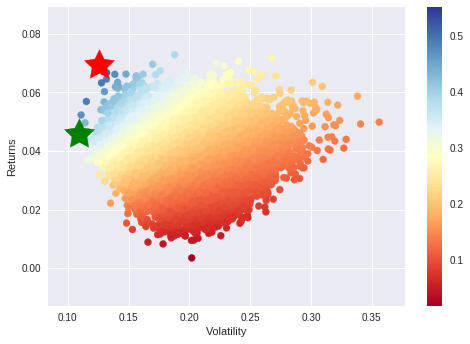

In [11]:
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import matplotlib.pyplot as plt


#list of stocks in portfolio
stocks = df.columns

#download daily price data for each of the stocks in the portfolio
data = df

data.sort_index(inplace=True)

#convert daily stock prices into daily returns
returns = data.pct_change()

#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

#set number of runs of random portfolio weights
num_portfolios = 25000

#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(stocks)-1,num_portfolios))

for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(len(stocks)))
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 35
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(35)
    
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

columns = ['ret','stdev','sharpe']
for i in stocks:
  columns.append(i)
#convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns=columns)

#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000)

In [12]:
print(max_sharpe_port)

ret       0.069457
stdev     0.125756
sharpe    0.552319
0012      0.035217
0017      0.068469
0683      0.008773
3323      0.076178
0158      0.639897
0062      0.103575
0066      0.067893
Name: 1528, dtype: float64


In [13]:
print(min_vol_port)

ret       0.045749
stdev     0.109160
sharpe    0.419095
0012      0.057554
0017      0.003039
0683      0.016687
3323      0.018982
0158      0.379142
0062      0.326208
0066      0.198389
Name: 9000, dtype: float64


In [14]:
import pandas_datareader.data as web
import numpy as np
import pandas as pd
 
stock = ['2800.HK']
 
data = pd.read_csv(r'C:\Users\alpin\Desktop\2800.HK.csv')['Adj Close']
 
data.sort_index(inplace=True)
 
returns = data.pct_change()
 
mean_return = returns.mean()
return_stdev = returns.std()
 
annualised_return = round(mean_return * 252,2)
annualised_stdev = round(return_stdev * np.sqrt(252),2)
 
print ('The annualised mean return of stock {} is {},and the annualised volatility is {}'.format (stock[0],annualised_return,annualised_stdev))

ModuleNotFoundError: ignored